In [16]:
module GlobalKldMclWorld

using Plots
using Distributions
using StatsBase
using LinearAlgebra
using Printf
using Logging
Logging.disable_logging(Logging.Info)

include("../scripts/kld_mcl.jl")
import .KldMclWorld: RealRobot, RealCamera
import .KldMclWorld: IdealAgent, Agent, EstimationAgent, TrueLandmark, Landmark, Map, Camera, Robot, World
import .KldMclWorld: data, decision, state_transition, circle_shape, draw, append
import .KldMclWorld: Estimator, Particle, set_ml, motion_update, observation_update, get_estimated_pose

mutable struct GlobalKldMcl <: Estimator
    max_num::Int64
    init_pose::Array{Float64}
    map::Map
    particles::Array{Particle}
    distance_dev_rate::Float64
    direction_dev::Float64
    motion_noise_rate_pdf::MvNormal
    ml::Particle
    pose::Array{Float64}
    widths::Array{Float64}
    epsilon::Float64
    delta::Float64
    binnum::Int64

    function GlobalKldMcl(
        max_num;
        init_pose=[0, 0, 0],
        map=Map(),
        particles=[Particle(init_pose, 1.0/max_num) for i in 1:max_num],
        distance_dev_rate=0.14,
        direction_dev=0.05,
        motion_noise_stds=Dict([("nn", 0.19), ("no", 0.001), ("on", 0.13), ("oo", 0.2)]),
        ml = particles[1],
        pose = ml.pose,
        widths=[0.2, 0.2, pi/18.0],
        epsilon=0.1,
        delta=0.01,
        binnum=0
        )
    
        c = diagm([motion_noise_stds["nn"]^2, motion_noise_stds["no"]^2, motion_noise_stds["on"]^2, motion_noise_stds["oo"]^2])
        motion_noise_rate_pdf = MvNormal([0, 0, 0, 0], c)

        updated_particles = [deepcopy(p) for p in particles]
        for p in updated_particles
            p.pose = [rand(Uniform(-5, 5)), rand(Uniform(-5, 5)), rand(Uniform(-pi, pi))]
        end
    
        new(
            max_num,
            init_pose,
            map,
            updated_particles,
            distance_dev_rate,
            direction_dev,
            motion_noise_rate_pdf,
            ml,
            pose,
            widths,
            epsilon,
            delta,
            binnum
        )
    end

end


end

Main.GlobalKldMclWorld

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_advanced_localization/tmp.gif")
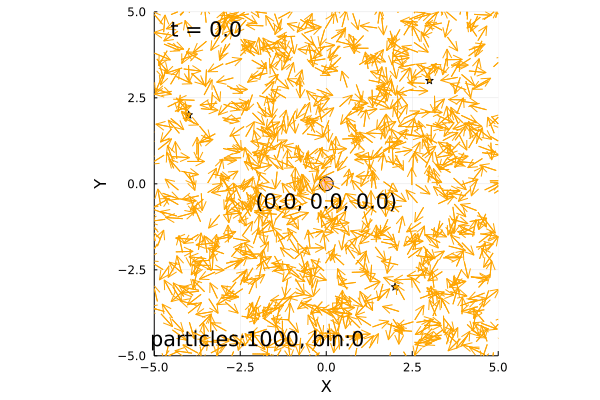

In [18]:
using .GlobalKldMclWorld
using Distributions

function trial(animation=true)
    time_interval = 0.1    
    world = GlobalKldMclWorld.World(30, 0.1)

    ### 地図を生成して2つランドマークを追加 ###
    m = GlobalKldMclWorld.Map()
    GlobalKldMclWorld.append(m, GlobalKldMclWorld.TrueLandmark([-4, 2]))
    GlobalKldMclWorld.append(m, GlobalKldMclWorld.TrueLandmark([2, -3]))
    GlobalKldMclWorld.append(m, GlobalKldMclWorld.TrueLandmark([3, 3]))
    GlobalKldMclWorld.append(world, m)
    
    #initial_pose = [rand(Uniform(-5, 5)), rand(Uniform(-5, 5)), rand(Uniform(-pi, pi))]
    initial_pose = [0.0, 0.0, rand(Uniform(-pi, pi))]
    pf = GlobalKldMclWorld.GlobalKldMcl(1000, map=m)
    a = GlobalKldMclWorld.EstimationAgent(time_interval, 0.2, 10.0/180.0*pi, pf)
    r = GlobalKldMclWorld.RealRobot(initial_pose, :red, 0.2, a, sensor=GlobalKldMclWorld.RealCamera(m))
    GlobalKldMclWorld.append(world, r)

    GlobalKldMclWorld.draw(world)

end

trial(false)